# Spotted!

AC215: Productionizing AI (MLOps)

Sunil Chomal, Alex Coward, Olga Leushina, Jonathan Sessa

## Model Training using WanDB

##**I. Environment Setup**

###I-1 Installs

In [ ]:
!pip install -q wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.8/224.8 kB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


###I-2 Imports

In [ ]:
# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical Libraries
import random as rn
import numpy as np
from scipy import stats as st

# File and System Libraries
import os
import pickle
import pathlib
import time

# TensorFlow Libraries
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, AveragePooling2D, GlobalAvgPool2D, Dense, Add, Flatten, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.activations import relu
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.python.keras import backend as K
from tensorflow.keras.utils import to_categorical

# SKLearn Dataset Management and Model Evaluation Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

# Tensorflow Hub
import tensorflow_hub as hub

# W&B
import wandb
from wandb.keras import WandbCallback, WandbMetricsLogger



###I-3 Verify setup

In [ ]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately,
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

tensorflow version 2.13.0
Eager Execution Enabled: True
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!nvidia-smi

Fri Oct  6 09:58:06 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    28W /  70W |    361MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [14]:
# Code that will be useful for serverless
# Create a MirroredStrategy.
# strategy = tf.distribute.MirroredStrategy()
# print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

# Open a strategy scope.
# with strategy.scope():
  # Everything that creates variables should be under the strategy scope.
  # In general this is only model construction & `compile()`.
#  model = Model(...)
#  model.compile(...)

# Train the model on all available devices.
# model.fit(train_dataset, validation_data=val_dataset, ...)

# Test the model on all available devices.
# model.evaluate(test_dataset)

####I-4 Connect to Drive for saving of models during training and experimentation

Model training was performed using Google Colab, with the weights and history for each model saved so the notebook can be edited and shared without having to re-train the models.

In [ ]:
# When True: Load model weights and history from saved data
# When False: Train all models anew (in Google Colab)
USE_SAVED_MODEL = False

# Google Colab Specific Code for loading/saving models
if USE_SAVED_MODEL:
    from google.colab import drive

    drive.mount('/content/gdrive')
    path = "/content/gdrive/MyDrive/spotted_project"
    os.chdir(path)

    # Use GPU for model training
    tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')

else:
    # Set working path to current directory
    path = "./"
    os.chdir(path)
    os.getcwd()

# Enable/Disable Eager Execution
tf.compat.v1.enable_eager_execution()

# Better performance with the tf.data API
AUTOTUNE = tf.data.AUTOTUNE

##**II. Dataset load and analysis**

###II-1 Load data into tf records

The Stanford Dogs dataset consists of 20,580 images of individual dogs classified among 120 different breeds.

In [ ]:
# Load data from TensorFlow Dataset
ds, ds_info = tfds.load("stanford_dogs",
                        split="train",
                        shuffle_files=True,
                        as_supervised=True,
                        with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteZB8XPI/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteZB8XPI/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
NUM_CLASSES = ds_info.features["label"].num_classes

###II-2 Exploratory Data Analysis

To better understand the images contained in the dataset and what preprocessing would be required, we examined the dimensionality of the images and checked for potential outliers.

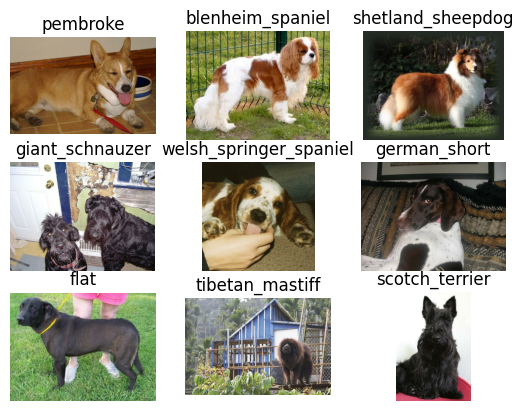

In [ ]:
# function to format labels (for Stanford dogs dataset)

def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[1]

# show examples (Stanford dog-specific with conversion of labels to nice format)
label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

#### Image Dimensions

Each image in the dataset is of a different dog (or dogs) with different background information and orientations.

In [ ]:
# Determine the widths and heights for all images
ds_iter = iter(ds)

widths, heights = [], []
min_width, min_height = 500, 500
max_width, max_height = 0, 0

# Determine largest width and height
for data in ds_iter:
    img = data[0]

    widths.append(img.shape[0])
    min_width = min(min_width, img.shape[0])
    max_width = max(max_width, img.shape[0])

    heights.append(img.shape[1])
    min_height = min(min_height, img.shape[1])
    max_height = max(max_height, img.shape[1])

print(f'Minimum Width: {min_width}; Minimum Height: {min_height}')
print(f'Maximum Width: {max_width}; Maximum Height: {max_height}')

Minimum Width: 103; Minimum Height: 97
Maximum Width: 2560; Maximum Height: 2740


In [ ]:
# Determine most common width and height
widths = np.array(widths)
heights = np.array(heights)

w_mode = st.mode(widths, keepdims=False)[0]
h_mode = st.mode(heights, keepdims=False)[0]

print(f'Most Common Width: {w_mode}')
print(f'Most Common Height: {h_mode}')

Most Common Width: 375
Most Common Height: 500


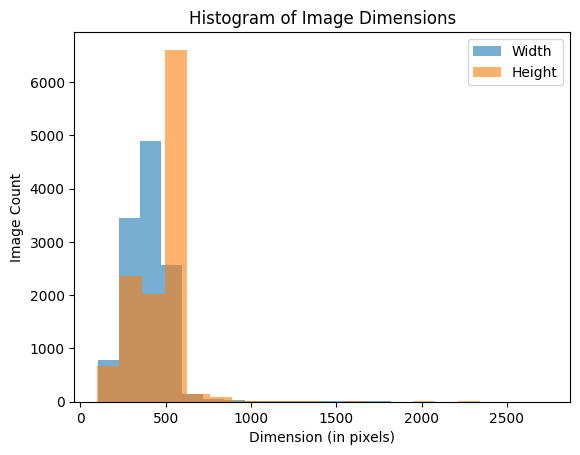

In [ ]:
# View distribution of image dimensions
plt.hist(widths, alpha=0.6, label='Width', bins=20)
plt.hist(heights, alpha=0.6, label='Height', bins=20)
plt.xlabel('Dimension (in pixels)')
plt.ylabel('Image Count')
plt.title('Histogram of Image Dimensions')
plt.legend();

The most common image dimensions are 375 pixels in width and 500 pixels in height. Depending on the model we choose, we will need to resize the images, but should use caution not to morph character features by changing the image aspect ratio.

###III-3 Data Preprocessing

#### Image Resizing and Padding

Due to differences in image sizes, we must resize our images so they all have the same dimension. However, we also want to preserve the aspect ratio so we do not warp animal features. As a result, we apply padding to the images after resizing.

In [ ]:
# Preprocess dataset to resize and normalize images
IMG_SIZE = 224
PAD_SIZE = 224
BATCH_SIZE = 64

# Resize image, pad to desired size, then normalize
def preprocess(image, label):
    # Resize image then pad to reach desired size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE], preserve_aspect_ratio=True)
    shape = tf.shape(image)
    top_pad = (PAD_SIZE - shape[0]) // 2
    left_pad = (PAD_SIZE - shape[1]) // 2
    image = tf.image.pad_to_bounding_box(image, top_pad, left_pad, PAD_SIZE, PAD_SIZE)

    # Convert value to float (for pre-processing)
    image = tf.cast(image, tf.float32)

    # One-hot categorical encoding for labels
    label = tf.one_hot(label, NUM_CLASSES)

    return image, label

##**III. Data Split with preprocessing**

We are using a 70-15-15 split for our training, validation, and testing data. We apply our preprocessing function to each dataset, as well as cache, batch, and prefetch our training/validaiton data to speed up training.

In [ ]:
tfds.disable_progress_bar()

# Create a 70/15/15 train/validation/test split
train_ds, val_ds, test_ds = tfds.load('stanford_dogs',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True,
                                      as_supervised=True)

train_ds = (
    train_ds
    .cache()
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

val_ds = (
    val_ds
    .cache()
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

test_ds = (
    test_ds
    .map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

##**IV. Experiment tracking**

In [ ]:
# Login to W&B account
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

##**V. MODELS**

###V-0. Shared parameters for models below

In [ ]:
project_name = "Stanford-dogs breeds"

###V-1. EfficientNetV2

For this example, we chose to use EfficientNetV2 B0 as our base model. EfficientNetV2 has shown a high level of classification accuracy when compared to other models, but with a fraction of the parameters. The smaller size of EfficientNet also allows us to train faster (which allows for easier experimentation and hyperparameter tuning).

#### EfficientNetV2 Model preparation

In [ ]:
model_name = "EfficientNetV2_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 64
epochs = 10
optimizer=keras.optimizers.Adam()
loss=CategoricalCrossentropy()

In [ ]:
# Load EfficientNet V2 B0 from keras.applications
base_model = keras.applications.EfficientNetV2B0(
    include_top=False,
    weights="imagenet",
    input_shape = (image_width, image_height, num_channels),
    include_preprocessing=False
)

# Freeze model weights for baseline evaluation
base_model.trainable = False

24274472/24274472 [==============================] - 0s 0us/step


We freeze the weights of the base model, and apply a Global Average Pooling layer to reduce the dimensionality of the model's output. We then use a dense layer with the same number of classes we are trying to predict and softmax activation to train the model to generate a prediction probability for each breed.

In [ ]:
# Input Layer
inputs = keras.Input(shape=(image_width, image_height, num_channels))

# Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# EfficientNet Base model (freezing batch normalization layers)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

# One nodes for categorical classification
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

# Output the model summary
model.summary()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

Model: "EfficientNetV2_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                         

#### EfficientNetV2 Feature Extraction - train the top layer

In [ ]:
# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()
if USE_SAVED_MODEL:
    # Load saved weights and model history
    model.load_weights("data/baseline_model")

    with open("data/baseline_model_hist.pickle", "rb") as filehandler:
        model_history = pickle.load(filehandler)

    print("Model weights and training history successfully loaded")

else:
    # Train the Model
    model_history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[WandbCallback()],
        validation_data=val_ds
    )

    # Create "data" directory if it does not yet exist
    if not os.path.exists("data"):
        os.mkdir("data")

    # Save training history dict using pickle
    with open("data/baseline_model_hist.pickle", "wb") as filehandler:
        model_history = model_history.history
        pickle.dump(model_history, filehandler)

    # Save model and weights for future use
    model.save_weights("data/baseline_model")

    print("Model weights and training history saved")

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})

# Close the W&B run
wandb.run.finish()

# Save execution time for summary
EfficientNetV2_base_model_execution_time = execution_time

Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 1.4654 - accuracy: 0.6352

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_121625-auoimydt/files/model-best)... Done. 3.7s


132/132 [==============================] - 64s 404ms/step - loss: 1.4654 - accuracy: 0.6352 - val_loss: 1.2771 - val_accuracy: 0.7933
Epoch 2/10
131/132 [============================>.] - ETA: 0s - loss: 0.4265 - accuracy: 0.8707

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_121625-auoimydt/files/model-best)... Done. 1.8s


132/132 [==============================] - 50s 380ms/step - loss: 0.4258 - accuracy: 0.8710 - val_loss: 0.7005 - val_accuracy: 0.8000
Epoch 3/10
131/132 [============================>.] - ETA: 0s - loss: 0.2367 - accuracy: 0.9423

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_121625-auoimydt/files/model-best)... Done. 0.8s


132/132 [==============================] - 47s 357ms/step - loss: 0.2363 - accuracy: 0.9424 - val_loss: 0.6297 - val_accuracy: 0.8022
Epoch 4/10
132/132 [==============================] - 14s 107ms/step - loss: 0.1429 - accuracy: 0.9718 - val_loss: 0.6300 - val_accuracy: 0.8000
Epoch 5/10
132/132 [==============================] - 14s 108ms/step - loss: 0.0930 - accuracy: 0.9849 - val_loss: 0.6376 - val_accuracy: 0.8000
Epoch 6/10
132/132 [==============================] - 14s 107ms/step - loss: 0.0650 - accuracy: 0.9927 - val_loss: 0.6481 - val_accuracy: 0.8061
Epoch 7/10
132/132 [==============================] - 14s 107ms/step - loss: 0.0482 - accuracy: 0.9961 - val_loss: 0.6591 - val_accuracy: 0.8050
Epoch 8/10
132/132 [==============================] - 14s 108ms/step - loss: 0.0375 - accuracy: 0.9979 - val_loss: 0.6699 - val_accuracy: 0.8044
Epoch 9/10
132/132 [==============================] - 14s 107ms/step - loss: 0.0303 - accuracy: 0.9982 - val_loss: 0.6798 - val_accuracy: 0.8

accuracy,▁▆▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▂▁▁▁▁▁▁
val_accuracy,▁▅▆▅▅█▇▇▇█
val_loss,█▂▁▁▁▁▁▁▂▂
accuracy,0.99833
best_epoch,2
best_val_loss,0.62972
epoch,9
loss,0.02515
val_accuracy,0.80556


#### EfficientNetV2 Fine-Tuning

In [ ]:
model_name = "EfficientNetV2_fine-tune"
learning_rate = 0.00001
optimizer=keras.optimizers.Adam(1e-5)

# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()

base_model.trainable = True
model.summary()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, callbacks=[WandbCallback()], validation_data = val_ds
)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})

# Close the W&B run
wandb.run.finish()

# Save execution time for summary
EfficientNetV2_final_model_execution_time = execution_time

Model: "EfficientNetV2_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                         

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_122233-rlxi1blu/files/model-best)... Done. 13.6s


132/132 [==============================] - 167s 882ms/step - loss: 0.0219 - accuracy: 0.9976 - val_loss: 0.6413 - val_accuracy: 0.8083
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9990

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_122233-rlxi1blu/files/model-best)... Done. 18.3s


132/132 [==============================] - 141s 1s/step - loss: 0.0148 - accuracy: 0.9990 - val_loss: 0.6336 - val_accuracy: 0.8144
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.0122 - accuracy: 0.9994

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_122233-rlxi1blu/files/model-best)... Done. 7.5s


132/132 [==============================] - 118s 898ms/step - loss: 0.0122 - accuracy: 0.9994 - val_loss: 0.6298 - val_accuracy: 0.8167
Epoch 4/10
132/132 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9995

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_122233-rlxi1blu/files/model-best)... Done. 9.8s


132/132 [==============================] - 112s 850ms/step - loss: 0.0103 - accuracy: 0.9995 - val_loss: 0.6275 - val_accuracy: 0.8189
Epoch 5/10
132/132 [==============================] - ETA: 0s - loss: 0.0089 - accuracy: 0.9998

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_122233-rlxi1blu/files/model-best)... Done. 11.3s


132/132 [==============================] - 120s 910ms/step - loss: 0.0089 - accuracy: 0.9998 - val_loss: 0.6264 - val_accuracy: 0.8217
Epoch 6/10
132/132 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_122233-rlxi1blu/files/model-best)... Done. 8.1s


132/132 [==============================] - 114s 864ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 0.6253 - val_accuracy: 0.8239
Epoch 7/10
132/132 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_122233-rlxi1blu/files/model-best)... Done. 10.4s


132/132 [==============================] - 111s 846ms/step - loss: 0.0067 - accuracy: 1.0000 - val_loss: 0.6252 - val_accuracy: 0.8261
Epoch 8/10
132/132 [==============================] - ETA: 0s - loss: 0.0059 - accuracy: 1.0000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_122233-rlxi1blu/files/model-best)... Done. 8.1s


132/132 [==============================] - 120s 910ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.6250 - val_accuracy: 0.8261
Epoch 9/10
132/132 [==============================] - 48s 361ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 0.6261 - val_accuracy: 0.8267
Epoch 10/10
132/132 [==============================] - 47s 359ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.6262 - val_accuracy: 0.8250
Training execution time (mins) 19.389623534679412


accuracy,▁▅▆▇▇█████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▃▄▅▆▇███▇
val_loss,█▅▃▂▂▁▁▁▁▁
accuracy,1.0
best_epoch,7
best_val_loss,0.62505
epoch,9
loss,0.00478
val_accuracy,0.825


#### EfficientNetV2 Prediction and testing accuracy

In [ ]:
from tensorflow.keras.utils import to_categorical
# Get model predictions on test set
y_pred = model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

29/29 [==============================] - 5s 106ms/step


In [ ]:
# Baseline Model accuracy
EfficientNetV2_testing_accuracy = accuracy_score(y_true, y_pred)
print(f"EfficientNetV2-based model testing accuracy (fine-tuned): {EfficientNetV2_testing_accuracy}")
print(f"Base model training time: {EfficientNetV2_base_model_execution_time}")
print(f"Final model training time: {EfficientNetV2_final_model_execution_time}")

EfficientNetV2-based model testing accuracy (fine-tuned): 0.825
Base model training time: 5.947090415159861
Final model training time: 19.389623534679412


###**V-2. XCeption**

####XCeption Model preparation

In [ ]:
model_name = "XCeption_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 64
epochs = 10
optimizer=keras.optimizers.Adam()
loss=CategoricalCrossentropy()

In [ ]:
# Load XCeption from keras.applications
base_model = keras.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape = (image_width, image_height, num_channels)
)

# Freeze model weights for baseline evaluation
base_model.trainable = False

83683744/83683744 [==============================] - 1s 0us/step


In [ ]:
# Input Layer
inputs = keras.Input(shape=(image_width, image_height, num_channels))

# Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# EfficientNet Base model (freezing batch normalization layers)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

# One nodes for categorical classification
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

# Output the model summary
model.summary()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

Model: "XCeption_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 prediction (Dense)          (None, 120)       

####XCeption Feature Extraction - train the top layer

In [ ]:
# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()

if USE_SAVED_MODEL:
    # Load saved weights and model history
    model.load_weights("data/baseline_model")

    with open("data/baseline_model_hist.pickle", "rb") as filehandler:
        model_history = pickle.load(filehandler)

    print("Model weights and training history successfully loaded")

else:
    # Train the Model
    model_history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[WandbCallback()],
        validation_data=val_ds
    )

    # Create "data" directory if it does not yet exist
    if not os.path.exists("data"):
        os.mkdir("data")

    # Save training history dict using pickle
    with open("data/baseline_model_hist.pickle", "wb") as filehandler:
        model_history = model_history.history
        pickle.dump(model_history, filehandler)

    # Save model and weights for future use
    model.save_weights("data/baseline_model")

    print("Model weights and training history saved")

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

XCeption_base_model_execution_time = execution_time

Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 1.3601 - accuracy: 0.6548

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_111252-gp03qa8n/files/model-best)... Done. 9.6s


132/132 [==============================] - 103s 703ms/step - loss: 1.3601 - accuracy: 0.6548 - val_loss: 1.0724 - val_accuracy: 0.7322
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.5059 - accuracy: 0.8449

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_111252-gp03qa8n/files/model-best)... Done. 8.5s


132/132 [==============================] - 81s 615ms/step - loss: 0.5059 - accuracy: 0.8449 - val_loss: 0.8986 - val_accuracy: 0.7400
Epoch 3/10
132/132 [==============================] - 41s 307ms/step - loss: 0.2654 - accuracy: 0.9275 - val_loss: 0.9406 - val_accuracy: 0.7439
Epoch 4/10
132/132 [==============================] - 43s 328ms/step - loss: 0.1538 - accuracy: 0.9635 - val_loss: 0.9648 - val_accuracy: 0.7494
Epoch 5/10
132/132 [==============================] - 44s 329ms/step - loss: 0.0977 - accuracy: 0.9807 - val_loss: 0.9668 - val_accuracy: 0.7506
Epoch 6/10
132/132 [==============================] - 43s 329ms/step - loss: 0.0683 - accuracy: 0.9887 - val_loss: 0.9765 - val_accuracy: 0.7544
Epoch 7/10
132/132 [==============================] - 44s 330ms/step - loss: 0.0515 - accuracy: 0.9925 - val_loss: 0.9978 - val_accuracy: 0.7567
Epoch 8/10
132/132 [==============================] - 43s 329ms/step - loss: 0.0413 - accuracy: 0.9943 - val_loss: 1.0199 - val_accuracy: 0.7

accuracy,▁▅▇▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▂▂▁▁▁▁▁▁
val_accuracy,▁▃▄▆▆▇█▇▇█
val_loss,█▁▃▄▄▄▅▆▆▇
accuracy,0.99607
best_epoch,1
best_val_loss,0.89857
epoch,9
loss,0.0284
val_accuracy,0.75778


####XCeption Fine-Tuning

In [ ]:
model_name = "Xception_fine-tune"
learning_rate = 0.00001
optimizer=keras.optimizers.Adam(1e-5)

# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()

base_model.trainable = True
model.summary()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, callbacks=[WandbCallback()], validation_data = val_ds
)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

XCeption_final_model_execution_time = execution_time

Model: "XCeption_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_4 (Bat  (None, 2048)              8192      
 chNormalization)                                                
                                                                 
 prediction (Dense)          (None, 120)       

132/132 [==============================] - ETA: 0s - loss: 0.0271 - accuracy: 0.9955

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_112727-wcjgnuxc/files/model-best)... Done. 37.3s


132/132 [==============================] - 291s 2s/step - loss: 0.0271 - accuracy: 0.9955 - val_loss: 1.0376 - val_accuracy: 0.7617
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 0.9976

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_112727-wcjgnuxc/files/model-best)... Done. 41.2s


132/132 [==============================] - 273s 2s/step - loss: 0.0152 - accuracy: 0.9976 - val_loss: 1.0157 - val_accuracy: 0.7689
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9983

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_112727-wcjgnuxc/files/model-best)... Done. 47.2s


132/132 [==============================] - 292s 2s/step - loss: 0.0097 - accuracy: 0.9983 - val_loss: 1.0057 - val_accuracy: 0.7683
Epoch 4/10
132/132 [==============================] - 133s 1s/step - loss: 0.0064 - accuracy: 0.9994 - val_loss: 1.0061 - val_accuracy: 0.7700
Epoch 5/10
132/132 [==============================] - ETA: 0s - loss: 0.0047 - accuracy: 0.9999

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_112727-wcjgnuxc/files/model-best)... Done. 14.2s


132/132 [==============================] - 209s 2s/step - loss: 0.0047 - accuracy: 0.9999 - val_loss: 1.0023 - val_accuracy: 0.7706
Epoch 6/10
132/132 [==============================] - 136s 1s/step - loss: 0.0039 - accuracy: 0.9999 - val_loss: 1.0047 - val_accuracy: 0.7706
Epoch 7/10
132/132 [==============================] - 136s 1s/step - loss: 0.0032 - accuracy: 0.9999 - val_loss: 1.0050 - val_accuracy: 0.7722
Epoch 8/10
132/132 [==============================] - 135s 1s/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 1.0055 - val_accuracy: 0.7733
Epoch 9/10
132/132 [==============================] - 133s 1s/step - loss: 0.0023 - accuracy: 1.0000 - val_loss: 1.0070 - val_accuracy: 0.7739
Epoch 10/10
132/132 [==============================] - 136s 1s/step - loss: 0.0020 - accuracy: 1.0000 - val_loss: 1.0084 - val_accuracy: 0.7744
Training execution time (mins) 33.056357153256734


accuracy,▁▄▅▇██████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▅▅▆▆▆▇▇██
val_loss,█▄▂▂▁▁▂▂▂▂
accuracy,1.0
best_epoch,4
best_val_loss,1.00226
epoch,9
loss,0.00204
val_accuracy,0.77444


#### XCeption Prediction and testing accuracy

In [ ]:
# Get model predictions on test set
y_pred = model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

29/29 [==============================] - 8s 239ms/step


In [ ]:
# Baseline Model accuracy
XCeption_testing_accuracy = accuracy_score(y_true, y_pred)
print(f"XCeption-based model testing accuracy: {XCeption_testing_accuracy}")
print(f"Base model training time: {XCeption_base_model_execution_time}")
print(f"Final model training time: {XCeption_final_model_execution_time}")

XCeption-based model testing accuracy: 0.7605555555555555
Base model training time: 12.87193105618159
Final model training time: 33.056357153256734


###**V-3. ResNet50V2**

####ResNet50V2 Model preparation

In [ ]:
model_name = "ResNet50V2_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 64
epochs = 10
optimizer=keras.optimizers.Adam()
loss=CategoricalCrossentropy()

In [ ]:
# Load ResNet50V2 from keras.applications
base_model = keras.applications.ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_shape = (image_width, image_height, num_channels)
)

# Freeze model weights for baseline evaluation
base_model.trainable = False

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
# Input Layer
inputs = keras.Input(shape=(image_width, image_height, num_channels))

# Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# EfficientNet Base model (freezing batch normalization layers)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

# One nodes for categorical classification
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

# Output the model summary
model.summary()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

Model: "ResNet50V2_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 prediction (Dense)          (None, 120)     

####ResNet50V2 Feature Extraction - train the top layer

In [ ]:
# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()
if USE_SAVED_MODEL:
    # Load saved weights and model history
    model.load_weights("data/baseline_model")

    with open("data/baseline_model_hist.pickle", "rb") as filehandler:
        model_history = pickle.load(filehandler)

    print("Model weights and training history successfully loaded")

else:
    # Train the Model
    model_history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[WandbCallback()],
        validation_data=val_ds
    )

    # Create "data" directory if it does not yet exist
    if not os.path.exists("data"):
        os.mkdir("data")

    # Save training history dict using pickle
    with open("data/baseline_model_hist.pickle", "wb") as filehandler:
        model_history = model_history.history
        pickle.dump(model_history, filehandler)

    # Save model and weights for future use
    model.save_weights("data/baseline_model")

    print("Model weights and training history saved")

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

ResNet50V2_base_model_execution_time = execution_time

wandb: Currently logged in as: oll583 (spotted-dog). Use `wandb login --relogin` to force relogin


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 1.9987 - accuracy: 0.5049

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_100220-p0t9ln8j/files/model-best)... Done. 0.3s


132/132 [==============================] - 63s 366ms/step - loss: 1.9987 - accuracy: 0.5049 - val_loss: 1.2584 - val_accuracy: 0.6639
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.5876 - accuracy: 0.8411

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_100220-p0t9ln8j/files/model-best)... Done. 0.3s


132/132 [==============================] - 46s 349ms/step - loss: 0.5876 - accuracy: 0.8411 - val_loss: 1.1883 - val_accuracy: 0.6639
Epoch 3/10
132/132 [==============================] - 27s 207ms/step - loss: 0.2679 - accuracy: 0.9500 - val_loss: 1.2091 - val_accuracy: 0.6617
Epoch 4/10
132/132 [==============================] - 28s 212ms/step - loss: 0.1362 - accuracy: 0.9861 - val_loss: 1.2260 - val_accuracy: 0.6667
Epoch 5/10
132/132 [==============================] - 27s 205ms/step - loss: 0.0819 - accuracy: 0.9937 - val_loss: 1.2464 - val_accuracy: 0.6733
Epoch 6/10
132/132 [==============================] - 28s 209ms/step - loss: 0.0560 - accuracy: 0.9969 - val_loss: 1.2685 - val_accuracy: 0.6756
Epoch 7/10
132/132 [==============================] - 27s 206ms/step - loss: 0.0414 - accuracy: 0.9976 - val_loss: 1.2875 - val_accuracy: 0.6794
Epoch 8/10
132/132 [==============================] - 28s 209ms/step - loss: 0.0321 - accuracy: 0.9982 - val_loss: 1.3044 - val_accuracy: 0.6

accuracy,▁▆▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▃▂▁▁▁▁▁▁▁
val_accuracy,▂▂▁▃▅▆▇██▇
val_loss,▄▁▂▃▄▅▆▇▇█
accuracy,0.99857
best_epoch,1
best_val_loss,1.18835
epoch,9
loss,0.02076
val_accuracy,0.67944


####ResNet50V2 Fine-Tuning

In [ ]:
model_name = "ResNetV2_fine-tune"
learning_rate = 0.00001
optimizer=keras.optimizers.Adam(1e-5)

# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()

base_model.trainable = True
model.summary()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, callbacks=[WandbCallback()], validation_data = val_ds
)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

ResNet50V2_final_model_execution_time = execution_time

Model: "ResNet50V2_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 2048)              0         
 ling2D)                                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 prediction (Dense)          (None, 120)     

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_101009-r8xdqkpq/files/model-best)... Done. 2.1s


132/132 [==============================] - 149s 850ms/step - loss: 0.0273 - accuracy: 0.9980 - val_loss: 1.3736 - val_accuracy: 0.6850
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.0126 - accuracy: 0.9985

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_101009-r8xdqkpq/files/model-best)... Done. 3.5s


132/132 [==============================] - 110s 834ms/step - loss: 0.0126 - accuracy: 0.9985 - val_loss: 1.3699 - val_accuracy: 0.6883
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.0077 - accuracy: 0.9994

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_101009-r8xdqkpq/files/model-best)... Done. 24.6s


132/132 [==============================] - 170s 1s/step - loss: 0.0077 - accuracy: 0.9994 - val_loss: 1.3024 - val_accuracy: 0.7022
Epoch 4/10
132/132 [==============================] - 77s 586ms/step - loss: 0.0032 - accuracy: 0.9999 - val_loss: 1.3083 - val_accuracy: 0.6989
Epoch 5/10
132/132 [==============================] - 77s 585ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 1.3039 - val_accuracy: 0.7006
Epoch 6/10
132/132 [==============================] - 77s 582ms/step - loss: 0.0017 - accuracy: 1.0000 - val_loss: 1.3033 - val_accuracy: 0.6989
Epoch 7/10
132/132 [==============================] - 77s 583ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.3033 - val_accuracy: 0.7006
Epoch 8/10
132/132 [==============================] - 77s 581ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.3039 - val_accuracy: 0.7017
Epoch 9/10
132/132 [==============================] - 77s 586ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 1.3045 - val_accuracy: 0.703

accuracy,▁▃▆███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▄▃▂▁▁▁▁▁▁
val_accuracy,▁▂▇▆▆▆▆▇▇█
val_loss,██▁▂▁▁▁▁▁▁
accuracy,1.0
best_epoch,2
best_val_loss,1.30239
epoch,9
loss,0.00088
val_accuracy,0.70611


#### ResNet50V2 Prediction and testing accuracy

In [ ]:
# Get model predictions on test set
y_pred = model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

29/29 [==============================] - 7s 166ms/step


In [ ]:
# Model accuracy and training time summary
ResNet50V2_testing_accuracy = accuracy_score(y_true, y_pred)
print(f"ResNet50V2 testing accuracy: {ResNet50V2_testing_accuracy}")
print(f"Base model training time: {ResNet50V2_base_model_execution_time}")
print(f"Final model training time: {ResNet50V2_final_model_execution_time}")

ResNet50V2 testing accuracy: 0.6822222222222222
Base model training time: 7.657653578122457
Final model training time: 16.479661762714386


###**V-4. VGG16**

####VGG16 Model preparation

In [ ]:
model_name = "VGG16_train_base"
learning_rate = 0.001
image_width = 224
image_height = 224
num_channels = 3
batch_size = 64
epochs = 10
optimizer=keras.optimizers.Adam()
loss=CategoricalCrossentropy()

In [ ]:
# Load EfficientNet VGG16 from keras.applications
base_model = keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape = (image_width, image_height, num_channels)
)

# Freeze model weights for baseline evaluation
base_model.trainable = False

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
# Input Layer
inputs = keras.Input(shape=(image_width, image_height, num_channels))

# Scales input from (0, 255) to a range of (-1., +1.) for EfficientNet
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# EfficientNet Base model (freezing batch normalization layers)
x = base_model(x, training=False)

x = layers.GlobalAveragePooling2D(name="avg_pool")(x)
x = layers.BatchNormalization()(x)

# One nodes for categorical classification
outputs = keras.layers.Dense(NUM_CLASSES, activation="softmax", name="prediction")(x)

# Create model
model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)

# Output the model summary
model.summary()

# Compile the model
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)

Model: "VGG16_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 512)               0         
 ling2D)                                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 prediction (Dense)          (None, 120)          

####VGG16 Feature Extraction - train the top layer

In [ ]:
# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)

# Free up memory
K.clear_session()

# Track time
start_time = time.time()
if USE_SAVED_MODEL:
    # Load saved weights and model history
    model.load_weights("data/baseline_model")

    with open("data/baseline_model_hist.pickle", "rb") as filehandler:
        model_history = pickle.load(filehandler)

    print("Model weights and training history successfully loaded")

else:
    # Train the Model
    model_history = model.fit(
        train_ds,
        epochs=epochs,
        callbacks=[WandbCallback()],
        validation_data=val_ds
    )

    # Create "data" directory if it does not yet exist
    if not os.path.exists("data"):
        os.mkdir("data")

    # Save training history dict using pickle
    with open("data/baseline_model_hist.pickle", "wb") as filehandler:
        model_history = model_history.history
        pickle.dump(model_history, filehandler)

    # Save model and weights for future use
    model.save_weights("data/baseline_model")

    print("Model weights and training history saved")

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

VGG16_base_model_execution_time = execution_time

Epoch 1/10
132/132 [==============================] - ETA: 0s - loss: 4.0649 - accuracy: 0.1137

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_103159-6xbn1x60/files/model-best)... Done. 5.3s


132/132 [==============================] - 79s 518ms/step - loss: 4.0649 - accuracy: 0.1137 - val_loss: 4.2719 - val_accuracy: 0.1083
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 2.6711 - accuracy: 0.3665

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_103159-6xbn1x60/files/model-best)... Done. 3.3s


132/132 [==============================] - 58s 441ms/step - loss: 2.6711 - accuracy: 0.3665 - val_loss: 3.4797 - val_accuracy: 0.2950
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 2.0766 - accuracy: 0.5040

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_103159-6xbn1x60/files/model-best)... Done. 5.7s


132/132 [==============================] - 62s 472ms/step - loss: 2.0766 - accuracy: 0.5040 - val_loss: 2.7709 - val_accuracy: 0.3711
Epoch 4/10
132/132 [==============================] - ETA: 0s - loss: 1.7169 - accuracy: 0.5886

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_103159-6xbn1x60/files/model-best)... Done. 8.5s


132/132 [==============================] - 62s 469ms/step - loss: 1.7169 - accuracy: 0.5886 - val_loss: 2.3934 - val_accuracy: 0.3978
Epoch 5/10
132/132 [==============================] - ETA: 0s - loss: 1.4624 - accuracy: 0.6533

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_103159-6xbn1x60/files/model-best)... Done. 4.7s


132/132 [==============================] - 60s 456ms/step - loss: 1.4624 - accuracy: 0.6533 - val_loss: 2.2607 - val_accuracy: 0.4089
Epoch 6/10
132/132 [==============================] - ETA: 0s - loss: 1.2657 - accuracy: 0.7046

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_103159-6xbn1x60/files/model-best)... Done. 7.6s


132/132 [==============================] - 64s 486ms/step - loss: 1.2657 - accuracy: 0.7046 - val_loss: 2.2226 - val_accuracy: 0.4083
Epoch 7/10
132/132 [==============================] - ETA: 0s - loss: 1.1054 - accuracy: 0.7475

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_103159-6xbn1x60/files/model-best)... Done. 6.6s


132/132 [==============================] - 61s 462ms/step - loss: 1.1054 - accuracy: 0.7475 - val_loss: 2.2145 - val_accuracy: 0.4183
Epoch 8/10
132/132 [==============================] - 44s 334ms/step - loss: 0.9702 - accuracy: 0.7900 - val_loss: 2.2209 - val_accuracy: 0.4228
Epoch 9/10
132/132 [==============================] - 44s 333ms/step - loss: 0.8538 - accuracy: 0.8248 - val_loss: 2.2380 - val_accuracy: 0.4233
Epoch 10/10
132/132 [==============================] - 40s 305ms/step - loss: 0.7522 - accuracy: 0.8529 - val_loss: 2.2635 - val_accuracy: 0.4244
Model weights and training history saved
Training execution time (mins) 11.806568018595378


accuracy,▁▃▅▅▆▇▇▇██
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▄▃▃▂▂▁▁▁
val_accuracy,▁▅▇▇██████
val_loss,█▅▃▂▁▁▁▁▁▁
accuracy,0.85286
best_epoch,6
best_val_loss,2.21454
epoch,9
loss,0.75217
val_accuracy,0.42444


####VGG16 Fine-tuning

In [ ]:
model_name = "VGG16_fine-tune"
learning_rate = 0.00001
optimizer=keras.optimizers.Adam(1e-5)

# Free up memory
K.clear_session()

# Initialize a W&B run
wandb.init(
    project = project_name,
    config = {
      "learning_rate": learning_rate,
      "epochs": epochs,
      "batch_size": batch_size,
      "model_name": model_name
    },
    name = model_name
)
# Track time
start_time = time.time()

base_model.trainable = True
model.summary()
model.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, validation_data = val_ds, callbacks=[WandbCallback()]
)

execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

# Update W&B
wandb.config.update({"execution_time": execution_time})
# Close the W&B run
wandb.run.finish()

VGG16_final_model_execution_time = execution_time

Model: "VGG16_train_base"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 avg_pool (GlobalAveragePoo  (None, 512)               0         
 ling2D)                                                         
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 prediction (Dense)          (None, 120)          

132/132 [==============================] - ETA: 0s - loss: 0.5539 - accuracy: 0.8806

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_104404-wvnjf1ts/files/model-best)... Done. 20.1s


132/132 [==============================] - 203s 1s/step - loss: 0.5539 - accuracy: 0.8806 - val_loss: 2.0838 - val_accuracy: 0.4761
Epoch 2/10
132/132 [==============================] - ETA: 0s - loss: 0.3126 - accuracy: 0.9611

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_104404-wvnjf1ts/files/model-best)... Done. 9.7s


132/132 [==============================] - 139s 1s/step - loss: 0.3126 - accuracy: 0.9611 - val_loss: 2.0277 - val_accuracy: 0.4933
Epoch 3/10
132/132 [==============================] - ETA: 0s - loss: 0.1975 - accuracy: 0.9873

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_104404-wvnjf1ts/files/model-best)... Done. 5.3s


132/132 [==============================] - 148s 1s/step - loss: 0.1975 - accuracy: 0.9873 - val_loss: 1.9869 - val_accuracy: 0.5033
Epoch 4/10
132/132 [==============================] - ETA: 0s - loss: 0.1323 - accuracy: 0.9956

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_104404-wvnjf1ts/files/model-best)... Done. 5.6s


132/132 [==============================] - 130s 989ms/step - loss: 0.1323 - accuracy: 0.9956 - val_loss: 1.9614 - val_accuracy: 0.5189
Epoch 5/10
132/132 [==============================] - ETA: 0s - loss: 0.0948 - accuracy: 0.9975

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_104404-wvnjf1ts/files/model-best)... Done. 8.8s


132/132 [==============================] - 138s 1s/step - loss: 0.0948 - accuracy: 0.9975 - val_loss: 1.9502 - val_accuracy: 0.5194
Epoch 6/10
132/132 [==============================] - ETA: 0s - loss: 0.0719 - accuracy: 0.9980

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_104404-wvnjf1ts/files/model-best)... Done. 5.5s


132/132 [==============================] - 129s 979ms/step - loss: 0.0719 - accuracy: 0.9980 - val_loss: 1.9467 - val_accuracy: 0.5156
Epoch 7/10
132/132 [==============================] - ETA: 0s - loss: 0.0569 - accuracy: 0.9980

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_104404-wvnjf1ts/files/model-best)... Done. 9.7s


132/132 [==============================] - 135s 1s/step - loss: 0.0569 - accuracy: 0.9980 - val_loss: 1.9461 - val_accuracy: 0.5133
Epoch 8/10
132/132 [==============================] - ETA: 0s - loss: 0.0465 - accuracy: 0.9982

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_104404-wvnjf1ts/files/model-best)... Done. 7.2s


132/132 [==============================] - 140s 1s/step - loss: 0.0465 - accuracy: 0.9982 - val_loss: 1.9408 - val_accuracy: 0.5172
Epoch 9/10
132/132 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9987

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_104404-wvnjf1ts/files/model-best)... Done. 10.3s


132/132 [==============================] - 136s 1s/step - loss: 0.0387 - accuracy: 0.9987 - val_loss: 1.9318 - val_accuracy: 0.5222
Epoch 10/10
132/132 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9988

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231006_104404-wvnjf1ts/files/model-best)... Done. 5.6s


132/132 [==============================] - 132s 1s/step - loss: 0.0328 - accuracy: 0.9988 - val_loss: 1.9220 - val_accuracy: 0.5294
Training execution time (mins) 24.368595719337463


accuracy,▁▆▇███████
epoch,▁▂▃▃▄▅▆▆▇█
loss,█▅▃▂▂▂▁▁▁▁
val_accuracy,▁▃▅▇▇▆▆▆▇█
val_loss,█▆▄▃▂▂▂▂▁▁
accuracy,0.99881
best_epoch,9
best_val_loss,1.92196
epoch,9
loss,0.03277
val_accuracy,0.52944


#### VGG16 Prediction and testing accuracy

In [ ]:
# Get model predictions on test set
y_pred = model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

29/29 [==============================] - 7s 245ms/step


In [ ]:
# Model accuracy and training time summary
VGG16_testing_accuracy = accuracy_score(y_true, y_pred)
print(f"VGG16 testing accuracy: {VGG16_testing_accuracy}")
print(f"Base model training time: {VGG16_base_model_execution_time}")
print(f"Final model training time: {VGG16_final_model_execution_time}")

VGG16 testing accuracy: 0.4988888888888889
Base model training time: 11.806568018595378
Final model training time: 24.368595719337463


##**VI. SUMMARY OF MODELS**

In [13]:
print ("1. EfficientNetV2 transfer learning ----------------------")
print(f"Accuracy on test dataset:       {round(EfficientNetV2_testing_accuracy,2)}")
print(f"Base model training time:             {round(EfficientNetV2_base_model_execution_time,2)}")
print(f"Final model training time:                   {round(EfficientNetV2_final_model_execution_time,2)}")
print()
print ("2. XCeption transfer learning ----------------------------")
print(f"Accuracy on test dataset:       {round(XCeption_testing_accuracy, 2)}")
print(f"Base model training time:             {round(XCeption_base_model_execution_time, 2)}")
print(f"Final model training time:                   {round(XCeption_final_model_execution_time, 2)}")
print()
print ("3. ResNet50V2 transfer learning --------------------------")
print(f"Accuracy on test dataset:       {round(ResNet50V2_testing_accuracy, 2)}")
print(f"Base model training time:             {round(ResNet50V2_base_model_execution_time, 2)}")
print(f"Final model training time:                   {round(ResNet50V2_final_model_execution_time, 2)}")
print()
print ("4. VGG16 transfer learning -------------------------------")
print(f"Accuracy on test dataset:       {round(VGG16_testing_accuracy, 2)}")
print(f"Base model training time:             {round(VGG16_base_model_execution_time, 2)}")
print(f"Final model training time:                   {round(VGG16_final_model_execution_time, 2)}")

1. EfficientNetV2 transfer learning ----------------------
Accuracy on test dataset:       0.82
Base model training time:             5.95
Final model training time:                   19.39

2. XCeption transfer learning ----------------------------
Accuracy on test dataset:       0.76
Base model training time:             12.87
Final model training time:                   33.06

3. ResNet50V2 transfer learning --------------------------
Accuracy on test dataset:       0.68
Base model training time:             7.66
Final model training time:                   16.48

4. VGG16 transfer learning -------------------------------
Accuracy on test dataset:       0.5
Base model training time:             11.81
Final model training time:                   24.37


##**VII. Download Model from WandB CODE**

####W&B Usage API

In [ ]:
run = wandb.init()
artifact = run.use_artifact('spotted-dog/Stanford-dogs%20breeds/model-VGG16_fine-tune', type='model')
artifact_dir = artifact.download()

In [ ]:
print("artifact_dir",artifact_dir)
# Load a model from artifact dir
prediction_model = tf.keras.models.load_model(artifact_dir)

prediction_model.summary()

##**We don't run this part anymore since we use wandb

In [ ]:
# Helper function for plotting training history
# Adapted from CS109B: Lab 8 Notebook

def plot_history(model_history, title):
    # plot 'Loss'
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    axs[0].plot(model_history['loss'], label='train')
    axs[0].plot(model_history['val_loss'], label='validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    best_loss = np.nanmin(model_history['val_loss'])
    axs[0].axvline(np.nanargmin(model_history['val_loss']),
                c='k', ls='--',
                label=f'best val loss = {best_loss:.2f}')
    axs[0].legend()
    axs[0].set_title('Loss')

    # in case the Network has multiple outputs
    train_accuracy = []
    val_accuracy = []

    for cur_history in model_history:
        if 'accuracy'in cur_history:
            if 'val' in cur_history:
                val_accuracy.append(model_history[cur_history])
            else:
                train_accuracy.append(model_history[cur_history])

    train_accuracy = np.mean(np.array(train_accuracy), axis=0)
    val_accuracy = np.mean(np.array(val_accuracy), axis = 0)

    # plot 'Accuracy'
    axs[1].plot(train_accuracy, label='train')
    axs[1].plot(val_accuracy, label='validation')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    best_accuracy = np.nanmax(val_accuracy)
    axs[1].axvline(np.nanargmax(val_accuracy),
                c='k', ls='--',
                label=f'best val accuracy = {best_accuracy:.5f}')
    axs[1].legend()
    axs[1].set_title('Accuracy')
    plt.suptitle(title)

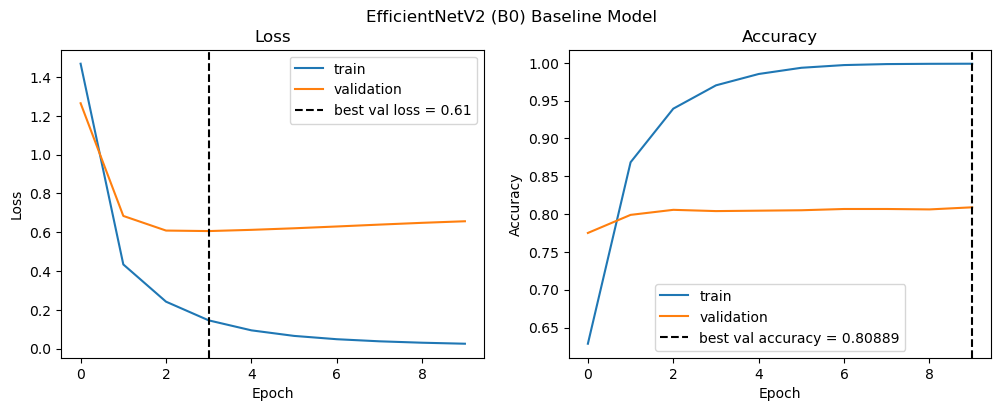

In [ ]:
# Plot the history of model training
plot_history(baseline_model_history, title = 'EfficientNetV2 (B0) Baseline Model')

After the first few epochs, validation accuraccy levels off. This can likely be attributed to not having any data augmentation and the model quickly learning all it can from the training data. Given the complexity of the problem, an accuracy of about 80% sounds good and shows that EfficientNet is likely a good baseline model to use and work from.

### Baseline Model Evaluation

After training the baseline model, we want to understands its accuracy when making predictions on the test dataset:

In [ ]:
# Get model predictions on test set
y_pred = baseline_model.predict(test_ds)
y_pred = to_categorical(np.argmax(y_pred, 1), dtype = "int64")

# Extract labels from test dataset
y_true = np.concatenate([y for x, y in test_ds], axis=0)

29/29 [==============================] - 16s 557ms/step


In [ ]:
# Baseline Model accuracy
print(f"Model testing accuracy: {accuracy_score(y_true, y_pred)}")

Model testing accuracy: 0.81


## Next Steps

To improve our model performance, we will include additional data as well as data augmentation using random transformations to increase the variety of training images.

We will also explore other potential models, as well as do additional training and fine-tuning on the selected model.